In [1]:
import numpy as np

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map = {"Alpha": r"$\alpha$", "Beta": r"$\beta$"})

# Analysis of a bioassay experiment

Example 3.7 from BDA3

In the development of drugs and other chemical compounds, acute toxicity tests or bioassay experiments are commonly performed on animals. Such experiments proceed by administering various dose levels of the compound to batches of animals. The animals’ responses are typically characterized by a dichotomous outcome: for example, alive or dead, tumor or no tumor. An experiment of this kind gives rise to data of the form $$(X_i,n_i,Y_i);\quad i=1,\ldots,k,$$ where $X_i$ represents the $i$ th of $k$ dose levels (often measured on a logarithmic scale) given to $n_i$ animals, of which $Y_i$ subsequently respond with positive outcome. An example of real data from such an experiment is shown in the next table, wherein twenty animals were tested, five at each of four dose levels.

| Dose, $X_i$ (log g/ml) | Number of animals, $n_i$ | Number of deaths, $Y_i$ |
|:----------------------:|:------------------------:|:-----------------------:|
| -0.86 | 5 | 0 |
| -0.3  | 5 | 1 |
| -0.05 | 5 | 3 |
| 0.73  | 5 | 5 |

Data from *Racine et al. (1986). Bayesian methods in practice: experiences in the pharmaceutical industry (with discussion). Applied Statistics*.

For these data, we could consider the following model $$Y_i|\theta_i\sim\textsf{Binomial}(n_i,\theta_i),$$ where $\theta_i$ is the probability of death for animals given dose $x_i$. The simplest model of the dose–response relation --that is, the relation of $\theta_i$ to $X_i$-- is linear: $\theta_i = \alpha + \beta X_i$. Unfortunately, this model has the flaw that at low or high doses (recall that the dose is measured on the log scale), $\theta_i$ approaches $\pm \infty$, whereas $\theta_i$, being a probability, must be constrained to lie between 0 and 1. The standard solution is to use a transformation of the $\theta$’s, such as the logistic, in the dose–response relation: $$\text{logit}(\theta_i)=\alpha+\beta X_i,$$ where $\text{logit}(\theta_i)=\log(\theta_i/(1-\theta_i))$. This is called a logistic regression model.

Thus, the likelihood for this data would be $$p(\mathbf{Y}|\alpha,\beta)=\prod_{i=1}^k p(Y_i|\theta_i)$$ $$p(\mathbf{Y}|\alpha,\beta)=\prod_{i=1}^k \theta_i^{Y_i}(1-\theta_i)^{n_i-Y_i}.$$ For the (hyper)prior we consider $p(\alpha,\beta)\propto 1$.

A parameter of common interest in bioassay studies is the LD50--the dose level at which the probability of death is 50%. In our logistic model, a 50% survival rate means $$\text{LD50: }\theta = \text{logit}^{-1}(\alpha+\beta x)=0.5;$$
thus, $\alpha + \beta x = \text{logit}(0.5) = 0$, and the LD50 is $x = -\alpha/\beta$.

In [3]:
XDose    = np.array([-0.86, -0.3, -0.05, 0.73])
NAnimals = np.array([5, 5, 5, 5])
YDeath   = np.array([0, 1, 3, 5])

In [4]:
with pm.Model() as ModelBioAssay:
    Alpha = pm.Flat('Alpha')
    Beta  = pm.Flat('Beta')
    
    Theta = pm.Deterministic('Theta', pm.math.invlogit(Alpha + Beta * XDose))
    LD50 = pm.Deterministic('LD50', -Alpha/Beta)

    Y = pm.Binomial('Y', n=NAnimals, p=Theta, observed=YDeath)

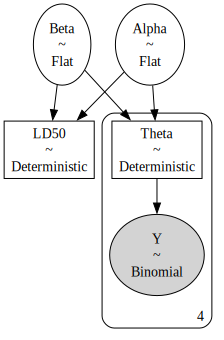

In [5]:
pm.model_to_graphviz(ModelBioAssay)

In [6]:
with ModelBioAssay:
    TraceBioAssay = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([[<Axes: >, None],
       [<Axes: xlabel='$\\alpha$', ylabel='$\\beta$'>, <Axes: >]],
      dtype=object)

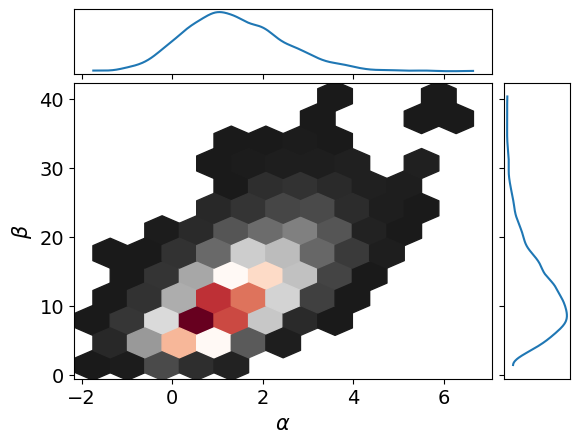

In [7]:
az.plot_pair(TraceBioAssay, var_names=['Alpha', 'Beta'], kind='hexbin', hexbin_kwargs={'cmap':'RdGy_r'}, labeller=labeller, marginals=True)

array([<Axes: title={'center': '$\\alpha$'}>,
       <Axes: title={'center': '$\\beta$'}>], dtype=object)

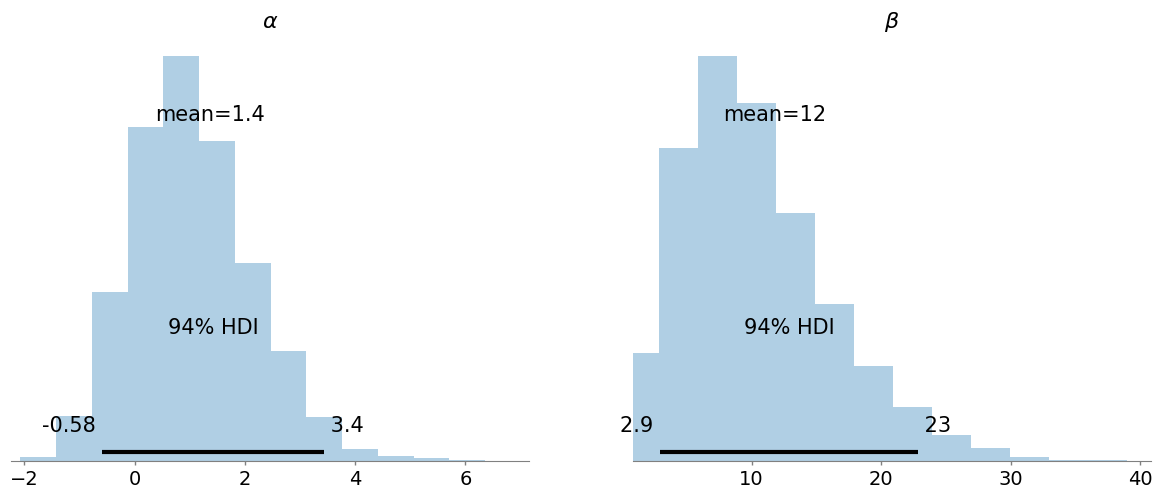

In [8]:
az.plot_posterior(TraceBioAssay, var_names=['Alpha', 'Beta'], kind='hist', labeller=labeller)

(-0.6, 0.5)

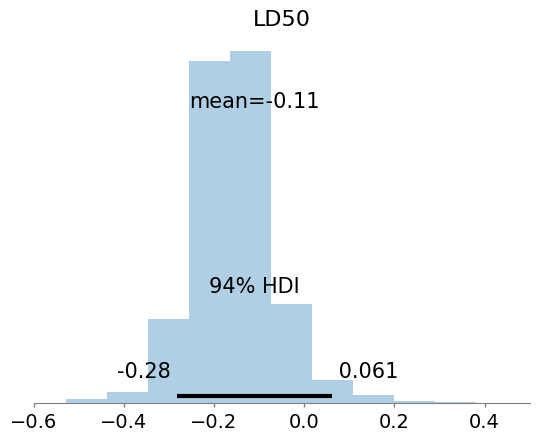

In [10]:
az.plot_posterior(TraceBioAssay, var_names=['LD50'], kind='hist')
plt.xlim(-0.6,0.5)